# Skeleton classifier using RNN


## Libraries and directory

In [1]:
#import packages, there might be some extras
import time
import os
import platform

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import keras.utils
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from IPython.display import HTML


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import imageio
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 'large'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Progetto_gait_recognition/dataset-20240610T153249Z-001.zip" -d "/content"

Archive:  /content/drive/MyDrive/Progetto_gait_recognition/dataset-20240610T153249Z-001.zip
  inflating: /content/dataset/subject4/lurching/trial1/Sbj4_lurching_T1_P.csv  
  inflating: /content/dataset/subject4/lurching/trial19/Sbj4_lurching_T19_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_P.csv  
  inflating: /content/dataset/subject4/lurching/trial20/Sbj4_lurching_T20_S.csv  
  inflating: /content/dataset/subject4/lurching/trial4/Sbj4_lurching_T4_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_S.csv  
  inflating: /content/dataset/subject4/lurching/trial9/Sbj4_lurching_T9_S.csv  
  inflating: /content/dataset/subject4/lurching/trial6/Sbj4_lurching_T6_S.csv  
  inflating: /content/dataset/subject4/lurching/trial17/Sbj4_lurching_T17_S.csv  
  inflating: /content/dataset/subject4/lurching/trial18/Sbj4_lurching_T18_P.csv  
  inflating: /content/dataset/subject4/lurching/trial11/Sbj4_lurching_T11_S.csv  
  inflating: /

In [4]:
if platform.system() == "Darwin":
    root_directory_work = '/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition'
else:
    root_directory = '/content'
    root_directory_work = '/content/drive/MyDrive/Progetto_gait_recognition'

print('root directory is ' + root_directory)

root directory is /content


## Train - Validation - Test Split


In [5]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv(root_directory_work +'/reference_document.csv',
                           header=None, names=['Name_file', 'Path_from_Root', 'Type_of_data', 'Type_of_gait', 'Label'])

reference_df = reference_df.iloc[1:]                            # fa iniziare il numero di colonne da 1 al posto che da zero
reference_df['Label'] = reference_df['Label'].astype(int)
reference_df['Subject'] = reference_df['Name_file'].str[:5].str.replace('_', '')

reference_df

,Name_file,Path_from_Root,Type_of_data,Type_of_gait,Label,Subject
1,Sbj9_antalgic_T2_S.csv,subject9/antalgic/trial2/,skeleton,antalgic,0,Sbj9
2,Sbj9_antalgic_T2_P.csv,subject9/antalgic/trial2/,pressure,antalgic,0,Sbj9
3,Sbj9_antalgic_T8_S.csv,subject9/antalgic/trial8/,skeleton,antalgic,0,Sbj9
4,Sbj9_antalgic_T8_P.csv,subject9/antalgic/trial8/,pressure,antalgic,0,Sbj9
5,Sbj9_antalgic_T14_P.csv,subject9/antalgic/trial14/,pressure,antalgic,0,Sbj9
...,...,...,...,...,...,...
2876,Sbj8_normal_T17_S.csv,subject8/normal/trial17/,skeleton,normal,2,Sbj8
2877,Sbj8_normal_T10_P.csv,subject8/normal/trial10/,pressure,normal,2,Sbj8
2878,Sbj8_normal_T10_S.csv,subject8/normal/trial10/,skeleton,normal,2,Sbj8
2879,Sbj8_normal_T6_P.csv,subject8/normal/trial6/,pressure,normal,2,Sbj8


In [6]:
def complete_path(row):
  complete_path = root_directory + '/dataset/' + row['Path_from_Root'] + row['Name_file']
  return complete_path

reference_df['Complete_path'] = reference_df.apply(complete_path, axis=1)
reference_df.set_index('Complete_path', inplace=True)                       # imposta Complete_path come indice per la mia tabella
reference_df = reference_df.drop(columns=['Path_from_Root'])
reference_df

,Name_file,Type_of_data,Type_of_gait,Label,Subject
Complete_path,,,,,
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_S.csv,Sbj9_antalgic_T2_S.csv,skeleton,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_P.csv,Sbj9_antalgic_T2_P.csv,pressure,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_S.csv,Sbj9_antalgic_T8_S.csv,skeleton,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_P.csv,Sbj9_antalgic_T8_P.csv,pressure,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial14/Sbj9_antalgic_T14_P.csv,Sbj9_antalgic_T14_P.csv,pressure,antalgic,0,Sbj9
...,...,...,...,...,...
/content/dataset/subject8/normal/trial17/Sbj8_normal_T17_S.csv,Sbj8_normal_T17_S.csv,skeleton,normal,2,Sbj8
/content/dataset/subject8/normal/trial10/Sbj8_normal_T10_P.csv,Sbj8_normal_T10_P.csv,pressure,normal,2,Sbj8
/content/dataset/subject8/normal/trial10/Sbj8_normal_T10_S.csv,Sbj8_normal_T10_S.csv,skeleton,normal,2,Sbj8


In [7]:
# recall
# LABELS = np.array(['antalgic', 'lurching', 'normal', 'steppage', 'stifflegged', 'trendelenburg'])

#split the dataframe into skeleton and pressure, drop the type column

reference_df_s = reference_df[reference_df['Type_of_data']=='skeleton']
reference_df_s = reference_df_s.drop(columns=['Type_of_data', 'Type_of_gait'])

reference_df_p = reference_df[reference_df['Type_of_data']=='pressure']
reference_df_p = reference_df_p.drop(columns=['Type_of_data', 'Type_of_gait'])


# We want to split the data using 10 subjects for training, 1 subject for validation and 1 subject for test
# In this way we are sure that train and test are completely dinstinct

# train_val_test split
train_s = reference_df_s[~reference_df_s['Name_file'].str.startswith('Sbj12')]
test_s = reference_df_s[reference_df_s['Name_file'].str.startswith('Sbj12')]

train_p = reference_df_p[~reference_df_p['Name_file'].str.startswith('Sbj12')]
test_p = reference_df_p[reference_df_p['Name_file'].str.startswith('Sbj12')]

#frequence counts
print("Train Skelly")
print(train_s['Label'].value_counts(), '\n')
print("Test Skelly")
print(test_s['Label'].value_counts(), '\n', '\n')
print("Train Pressure")
print(train_p['Label'].value_counts(), '\n')
print("Test Pressure")
print(test_p['Label'].value_counts())

print(len(train_p))

train_p

Train Skelly
Label
0    220
4    220
5    220
3    220
2    220
1    220
Name: count, dtype: int64 

Test Skelly
Label
5    20
4    20
0    20
3    20
2    20
1    20
Name: count, dtype: int64 
 

Train Pressure
Label
0    220
4    220
5    220
3    220
2    220
1    220
Name: count, dtype: int64 

Test Pressure
Label
5    20
4    20
0    20
3    20
2    20
1    20
Name: count, dtype: int64
1320


,Name_file,Label,Subject
Complete_path,,,
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_P.csv,Sbj9_antalgic_T2_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_P.csv,Sbj9_antalgic_T8_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial14/Sbj9_antalgic_T14_P.csv,Sbj9_antalgic_T14_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial4/Sbj9_antalgic_T4_P.csv,Sbj9_antalgic_T4_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial7/Sbj9_antalgic_T7_P.csv,Sbj9_antalgic_T7_P.csv,0,Sbj9
...,...,...,...
/content/dataset/subject8/normal/trial20/Sbj8_normal_T20_P.csv,Sbj8_normal_T20_P.csv,2,Sbj8
/content/dataset/subject8/normal/trial19/Sbj8_normal_T19_P.csv,Sbj8_normal_T19_P.csv,2,Sbj8
/content/dataset/subject8/normal/trial17/Sbj8_normal_T17_P.csv,Sbj8_normal_T17_P.csv,2,Sbj8


## Skeleton Processing

In [8]:
# def len_data_sk(complete_path, load=True):

#     if load:
#         complete_path = complete_path.decode()

#     df_skelly = pd.read_csv(complete_path, header=None)
#     df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

#     #convert to np array and reshape
#     data = df_skelly.to_numpy().reshape((-1,32,3))
#     l = data.shape[0]

#     return np.float32(l)


# def create_dataset_sk(table, cache_file, shuffle, batch_size, target_size=75, noise_time=20, center_crop=False, flip=False, repeat=True):

#   # shape
#   input_size = (target_size, 32, 3)

#   # Convert dataframe to lists
#   file_names = list(table.index)
#   labels = table['Label']

#   # Create a Dataset object
#   dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
#   # Now, 'dataset' contains tuples of 'file_names' and 'labels', where each tuple represents a single example

#   # Map the load_and_preprocess_data function
#   py_func = lambda path, label: (tf.numpy_function(len_data_sk, [path], tf.float32), label)
#   dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

#   # Cache dataset
#   if cache_file:
#       dataset = dataset.cache(cache_file)

#   # Shuffle
#   if shuffle:
#       dataset = dataset.shuffle(len(file_names))

#   # Repeat the dataset indefinitely
#   if repeat:
#     dataset = dataset.repeat()

#   # Batch
#   dataset = dataset.batch(batch_size=batch_size)

#   # Prefetch
#   dataset = dataset.prefetch(buffer_size=1)

#   return dataset

# batch_s = 3000

# dataset_train_s = create_dataset_sk(table = train_s,
#                                     cache_file = False,
#                                     shuffle = False,
#                                     batch_size = batch_s,
#                                     target_size = 75,
#                                     noise_time = 20,
#                                     center_crop = False,
#                                     flip = False,
#                                     repeat=False)

# train_steps_s = int(np.ceil(len(train_s)/batch_s))

# first_element_dataset_k = dataset_train_s.take(1)
# first_element_dataset_k

# for d, l in first_element_dataset_k:
#   print(d.numpy().shape, l.numpy().shape)

# plt.hist(d.numpy(), bins=30, edgecolor='black')

# # Impostare le etichette degli assi e il titolo
# plt.xlabel('Valore')
# plt.ylabel('Frequenza')
# plt.title('Istogramma dei valori')

# # Mostrare l'istogramma
# plt.show()

/content/dataset/subject1/normal/trial9/Sbj1_normal_T9_S.csv
Original shape  (118, 32, 3)


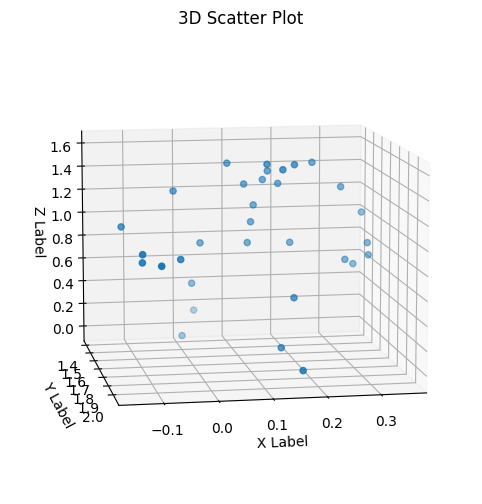

In [9]:
def load_data_sk(complete_path, load=True):

    if load:
        complete_path = complete_path.decode()

    df_skelly = pd.read_csv(complete_path, header=None)
    df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

    #convert to np array and reshape
    data = df_skelly.to_numpy().reshape((-1,32,3))

    # return data.shape[0]
    return data.squeeze()


# Example
index = train_s.index[756]
sk_data = load_data_sk(index, load=False)
sk_data
print(index)
print('Original shape ', sk_data.shape)

plotdata = sk_data[100]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
ax.invert_xaxis()
plt.show()

# # Create a function to update the plot
# def update(frame, data):
#     ax.cla()
#     sc = ax.scatter(data[frame,:, 0], data[frame,:, 1], data[frame,:, 2])
#     ax.invert_xaxis()
#     return sc

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(sk_data), fargs=(sk_data,), blit=False)

# # Display the animation
# load_sk = HTML(ani.to_jshtml())


In [10]:
# load_sk

In [11]:
joint_dataframe = {'SPINE' : ['0 - PELVIS', '1 - SPINE_NAVAL', '2 - SPINE_CHEST', '3 - NECK', '', '', ''],
                   'LEFT ARM': ['4 - CLAVICLE_LEFT', '5 - SHOULDER_LEFT', '6 - ELBOW_LEFT', '7 - WRIST_LEFT', '8 - HAND_LEFT', '9 - HANDTIP_LEFT', '10 - THUMB_LEFT'],
                   'RIGHT ARM': ['11 - CLAVICLE_RIGHT', '12 - SHOULDER_RIGHT', '13 - ELBOW_RIGHT', '14 - WRIST_RIGHT', '15 - HAND_RIGHT', '16 - HANDTIP_RIGHT', '17 - THUMB_RIGHT'],
                   'LEFT LEG': ['18 - HIP_LEFT', '19 - KNEE_LEFT', '20 - ANKLE_LEFT', '21 - FOOT_LEFT', '', '', ''],
                   'RIGHT LEG': ['22 - HIP_RIGHT', '23 - KNEE_RIGHT', '24 - ANKLE_RIGHT', '25 - FOOT_RIGHT', '', '', ''],
                   'HEAD': ['26 - HEAD', '27 - NOSE', '28 - EYE_LEFT', '29 - EAR_LEFT', '30 - EYE_RIGHT', '31 - EAR_RIGHT', '']}

joint_df = pd.DataFrame(joint_dataframe)
joint_df

,SPINE,LEFT ARM,RIGHT ARM,LEFT LEG,RIGHT LEG,HEAD
0,0 - PELVIS,4 - CLAVICLE_LEFT,11 - CLAVICLE_RIGHT,18 - HIP_LEFT,22 - HIP_RIGHT,26 - HEAD
1,1 - SPINE_NAVAL,5 - SHOULDER_LEFT,12 - SHOULDER_RIGHT,19 - KNEE_LEFT,23 - KNEE_RIGHT,27 - NOSE
2,2 - SPINE_CHEST,6 - ELBOW_LEFT,13 - ELBOW_RIGHT,20 - ANKLE_LEFT,24 - ANKLE_RIGHT,28 - EYE_LEFT
3,3 - NECK,7 - WRIST_LEFT,14 - WRIST_RIGHT,21 - FOOT_LEFT,25 - FOOT_RIGHT,29 - EAR_LEFT
4,,8 - HAND_LEFT,15 - HAND_RIGHT,,,30 - EYE_RIGHT
5,,9 - HANDTIP_LEFT,16 - HANDTIP_RIGHT,,,31 - EAR_RIGHT
6,,10 - THUMB_LEFT,17 - THUMB_RIGHT,,,


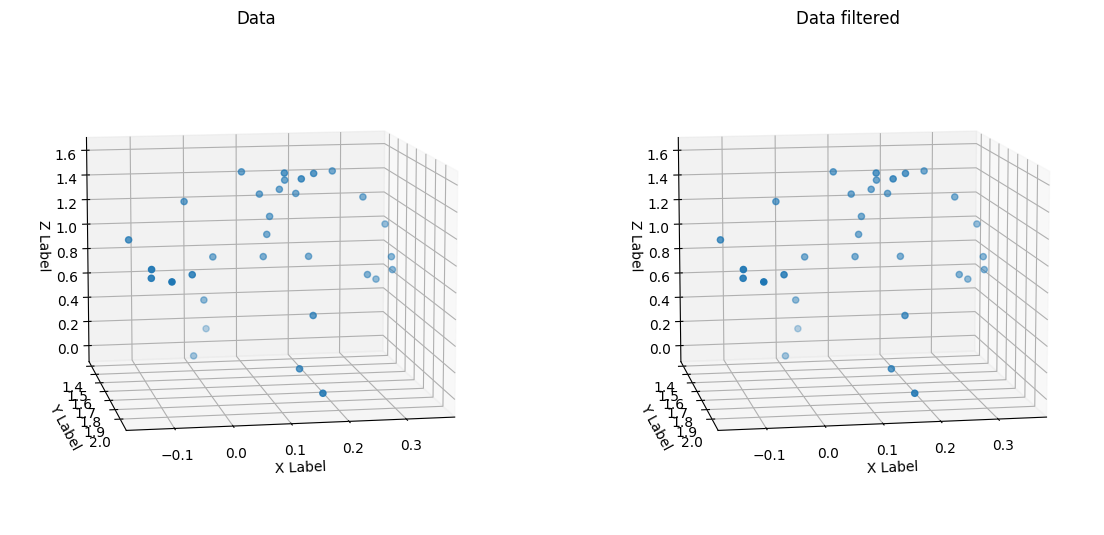

In [12]:
def remove_joints(data, joint_list, load=True):

    mask=np.ones(32,dtype=bool)

    if len(joint_list) == 0:
        pass
        # print('no filtering')

    else:
        for joint in joint_list:

            if load:
                joint = joint.decode()

            if type(joint) == str:

                if joint == 'head':
                    joint_num = [26,27,28,29,30,31]

                elif joint == 'rleg':
                    joint_num = [22,23,24,25]

                elif joint == 'lleg':
                    joint_num = [18,19,20,21]

                elif joint == 'rarm':
                    joint_num = [11,12,13,14,15,16,17]

                elif joint == 'larm':
                    joint_num = [4,5,6,7,8,9,10]

                elif joint == 'spine':
                    joint_num = [0,1,2,3]

                else:
                    print('unknown keyword, returning to default')
                    mask=np.ones(len(data),dtype=bool)
                    break


            else:
                joint_num = [joint]


            for j in joint_num:
                mask[j]=0

    filtered_skelly = data[:, mask, :]

    return filtered_skelly


# Example
index = train_s.index[756]
sk_data = load_data_sk(index, load=False)
sk_data_filter = remove_joints(sk_data, [], load=False)

plotdata = sk_data[100]
plotdata_fil = sk_data_filter[100]

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('Data')
ax1.view_init(elev=10, azim=80)
ax1.invert_xaxis()

ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(plotdata_fil[:, 0], plotdata_fil[:, 1], plotdata_fil[:, 2])
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('Data filtered')
ax2.view_init(elev=10, azim=80)
ax2.invert_xaxis()

plt.show()

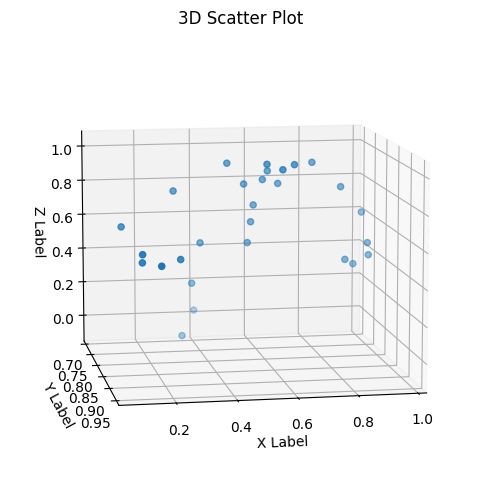

In [13]:
def normalize_data_sk(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
    norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
    norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

    data[:, :, 0] = (data[:, :, 0] - np.percentile(data[:, :, 0], 5)) / norm_factor_x
    data[:, :, 1] = (data[:, :, 1] - np.percentile(data[:, :, 1], 5)) / norm_factor_y
    data[:, :, 2] = (data[:, :, 2] - np.percentile(data[:, :, 2], 5)) / norm_factor_z

    return data


# Example
sk_data = load_data_sk(index, load=False)
sk_data_filter = remove_joints(sk_data, ['rleg'], load=False)
sk_data_norm = normalize_data_sk(sk_data_filter)


#plot example, select only one frame
plotdata = sk_data_norm[100]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
ax.invert_xaxis()
plt.show()


# # Create a function to update the plot
# def update(frame, data):
#     ax.cla()
#     sc = ax.scatter(data[frame,:, 0], data[frame,:, 1], data[frame,:, 2])
#     ax.invert_xaxis()
#     return sc

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(sk_data_norm), fargs=(sk_data_norm,), blit=False)

# # Display the animation
# norm_sk = HTML(ani.to_jshtml())

In [14]:
# norm_sk

Original shape  (118, 32, 3) Cropped/Padded shape  (50, 28, 3)


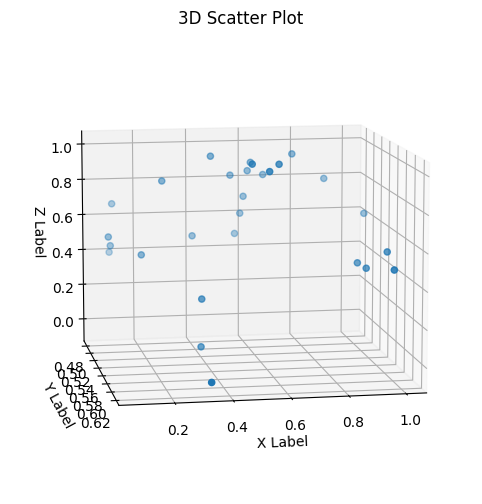

In [15]:
def random_crop(data, target_size=50, center_crop=False):

  noise_time_begin = int(data.shape[0]/2) - 10
  noise_time_end = 5

  # remove initial and final frames that we consider as noise
  start = noise_time_begin
  end = data.shape[0] - noise_time_end

  data = data[start:end, :]

  N = data.shape[0]

  # Random Crop (always centered if center_crop=True)
  if center_crop:
      from_ = int((N / 2) - (target_size / 2))
      # print('Start of the crop: ', from_)
  else:
      from_ = np.random.randint(0, np.floor(N - target_size))
      # print('Start of the crop: ', from_)

  return data[from_:from_ + target_size]


# Example
sk_data = load_data_sk(index, load=False)
sk_data_filter = remove_joints(sk_data, ['rleg'], load=False)
sk_data_norm = normalize_data_sk(sk_data_filter)

sk_data_crop = random_crop(sk_data_norm)
print('Original shape ', sk_data.shape, 'Cropped/Padded shape ', sk_data_crop.shape)

plotdata = sk_data_crop[20]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
ax.invert_xaxis()
plt.show()


# # Create a function to update the plot
# def update(frame, data):
#     ax.cla()
#     sc = ax.scatter(data[frame,:, 0], data[frame,:, 1], data[frame,:, 2])
#     ax.invert_xaxis()
#     return sc

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(sk_data_crop), fargs=(sk_data_crop,), blit=False)

# # Display the animation
# crop_sk = HTML(ani.to_jshtml())

In [16]:
# crop_sk

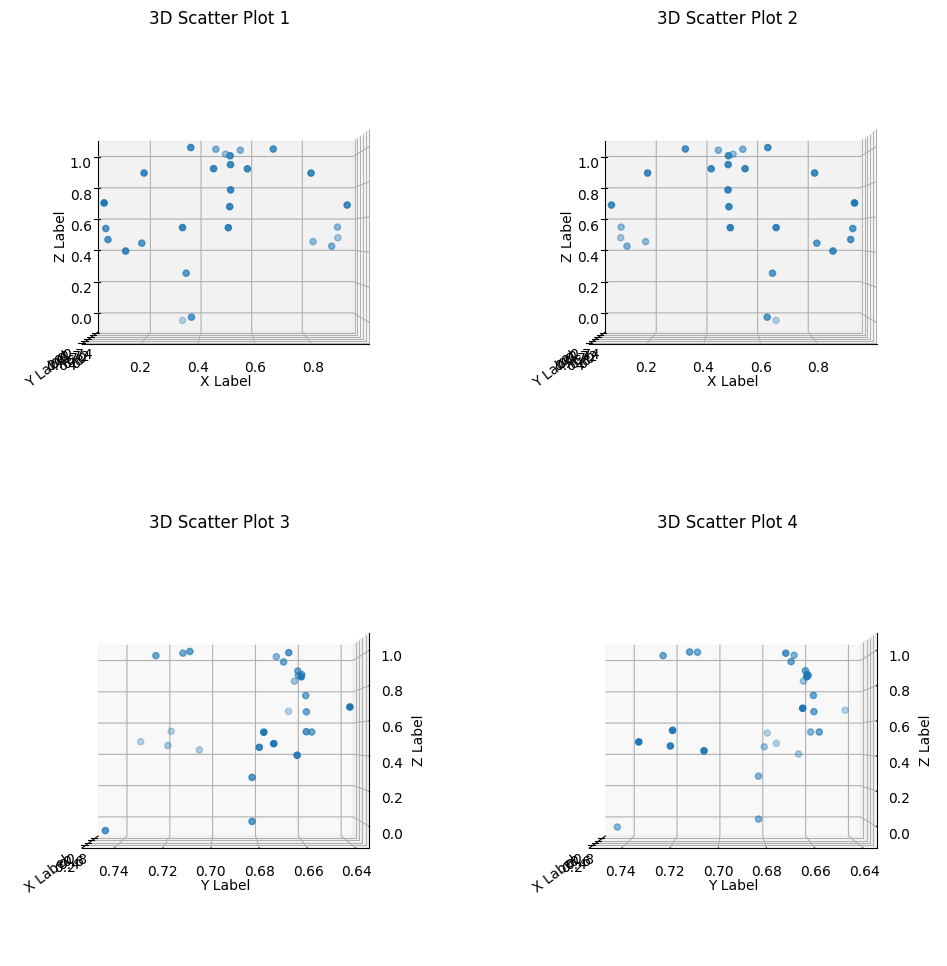

In [17]:
def random_flip(data, prob_flip=0.5):

    data = data.reshape(len(data),-1,3)

    x_data = data[:, :, 0]
    y_data = data[:, :, 1]
    z_data = data[:, :, 2]

    p = np.random.rand()

    if p < prob_flip:
        # print('Inversione avvenuta')
        x_data = 1 - x_data



    data_flip = np.dstack((x_data, y_data, z_data)).reshape(len(data),-1)

    return data_flip


# Example
sk_data_flip = random_flip(sk_data_crop, prob_flip=1)

frame = 30
plotdata = sk_data_crop[frame].reshape(-1,3)
plotdata_f = sk_data_flip[frame].reshape(-1,3)


fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('3D Scatter Plot 1')
ax1.view_init(elev=0, azim=-90)

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(plotdata_f[:, 0], plotdata_f[:, 1], plotdata_f[:, 2])
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('3D Scatter Plot 2')
ax2.view_init(elev=0, azim=-90)

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax3.set_xlabel('X Label')
ax3.set_ylabel('Y Label')
ax3.set_zlabel('Z Label')
ax3.set_title('3D Scatter Plot 3')
ax3.view_init(elev=0, azim=-180)

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(plotdata_f[:, 0], plotdata_f[:, 1], plotdata_f[:, 2])
ax4.set_xlabel('X Label')
ax4.set_ylabel('Y Label')
ax4.set_zlabel('Z Label')
ax4.set_title('3D Scatter Plot 4')
ax4.view_init(elev=0, azim=-180)

plt.show()

In [18]:
def load_prep_sk(complete_path, joints, load = True):
    data = load_data_sk(complete_path, load)
    data = normalize_data_sk(data)
    data = remove_joints(data, joints)

    data = data.reshape(len(data),-1)

    return data.astype(np.float32)


## Dataset

In [19]:
def create_dataset_sk(table, cache_file, shuffle, batch_size, num_sbj, num_joints=32, remove_joints=False, target_size=50, center_crop=False, train=False, validation=False, test=False, flip_rate=0.5, repeat=True):

  subject_0 = 'Sbj' + str(num_sbj)
  # subject_1 = 'Sbj' + str(num_sbj+1)

  if num_sbj == 0:
      new_table = table

  else:
      if train:
        new_table = table[table['Subject'] != subject_0]
        # new_table = table[~table['Name_file'].str.startswith(subject_0) & ~table['Name_file'].str.startswith(subject_1)]

      elif validation:
        new_table = table[table['Subject'] == subject_0]
        # new_table = table[table['Name_file'].str.startswith(subject_0) | table['Name_file'].str.startswith(subject_1)]

      elif test:
        new_table = table

      else:
        print("Error, select train, validation or test setting")
        return None

  # print(new_table)

  input_size = (target_size, num_joints*3)

  # Convert dataframe to lists
  file_names = list(new_table.index)
  labels = new_table['Label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_sk, [path, remove_joints], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Repeat the dataset indefinitely
  if repeat:
    dataset = dataset.repeat()

  # Map the crop function
  py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_crop, [data, target_size, center_crop], tf.float32), input_size), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Map the flip function
  if flip_rate:
     py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_flip, [data], tf.float32), input_size), label)
     dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

In [20]:
# batch_sk = 30

# sbj = 1
# train_name_file = 'train_s_00' + str(sbj)

# dataset_train_sk = create_dataset_sk(table = train_s,
#                                      remove_joints = [],
#                                      num_joints = 32,
#                                      cache_file = train_name_file,
#                                      shuffle = True,
#                                      batch_size = batch_sk,
#                                      num_sbj = sbj,
#                                      train = True)



# train_steps_sk = int(np.ceil(1200/batch_sk))

# first_element_dataset_sk = dataset_train_sk.take(1)
# first_element_dataset_sk

# for d, l in first_element_dataset_sk:
#   print(d.numpy().shape, l.numpy().shape)

# num_joints = d.numpy().shape[2]

## RNN model

In [21]:
def cls(X, l=0.01):

    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(l))(X)
    X = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(l))(X)
    X = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(l))(X)

    return X

In [22]:
def RNN_sk(time_length, n_features, code_size):

  X_input = tf.keras.Input((time_length, n_features))

  # Linear_part
  X = tf.keras.layers.Dense(units=n_features, activation='relu')(X_input)

  # RNN part
  # h(t) = tanh(W_hx * x(t) + W_hh * h(t-1) + bias)
  X = tf.keras.layers.GRU(256, return_sequences=True, activation='tanh', name='I_GRU')(X)
  X = tf.keras.layers.GRU(256, return_sequences=True, activation='tanh', name='II_GRU')(X)
  X = tf.keras.layers.GRU(128, return_sequences=True, activation='tanh', name='III_GRU')(X)
  X = tf.keras.layers.GRU(128, return_sequences=False, activation='tanh', name='IV_GRU')(X)

  # Flatten_output
  X = tf.keras.layers.Flatten()(X)
  X_internal = tf.keras.layers.Dense((code_size))(X)

  X = cls(X_internal, l=0.01)
  X_out = tf.keras.layers.Dense(6, activation='softmax')(X)

  model = tf.keras.Model(inputs = X_input, outputs = X_out, name='RNN_sk_classifier')

  return model

In [23]:
num_joints = 12
code_size = 200


RNN_classifier = RNN_sk(50, int(3*num_joints), code_size)
RNN_classifier.summary()

Model: "RNN_sk_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 36)]          0         
                                                                 
 dense (Dense)               (None, 50, 36)            1332      
                                                                 
 I_GRU (GRU)                 (None, 50, 256)           225792    
                                                                 
 II_GRU (GRU)                (None, 50, 256)           394752    
                                                                 
 III_GRU (GRU)               (None, 50, 128)           148224    
                                                                 
 IV_GRU (GRU)                (None, 128)               99072     
                                                                 
 flatten (Flatten)           (None, 128)         

## K-fold cross validation

In [24]:
batch_sk = 30
lr = 0.0001
train_steps_sk = int(np.ceil(1200/batch_sk))
val_steps_sk = int(np.ceil(120/batch_sk))

validation_loss = []
validation_accuracy = []
epochs = []
conf_matrix = np.zeros((6,6))

for i in np.arange(1, 12):

    sbj = i
    train_name_file = 'train_s_' + str(sbj)
    val_name_file = 'val_s_' + str(sbj)

    dataset_train_sk = create_dataset_sk(table = train_s,
                                        remove_joints = ['rarm', 'larm', 'head'],
                                        cache_file = train_name_file,
                                        num_joints = 12,
                                        shuffle = True,
                                        batch_size = batch_sk,
                                        num_sbj = sbj,
                                        train = True)

    dataset_val_sk = create_dataset_sk(table = train_s,
                                       remove_joints = ['rarm', 'larm', 'head'],
                                       num_joints = 12,
                                       cache_file = val_name_file,
                                       shuffle = True,
                                       batch_size = batch_sk,
                                       num_sbj = sbj,
                                       validation = True)

    RNN_classifier = RNN_sk(50, int(3*num_joints), code_size)

    RNN_classifier.compile(optimizer = keras.optimizers.Adam(learning_rate=lr), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    num_epochs = 350

    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=20)

    results = RNN_classifier.fit(dataset_train_sk,
                      epochs=num_epochs,
                      steps_per_epoch=train_steps_sk,
                      validation_data=dataset_val_sk,
                      validation_steps=val_steps_sk,
                      callbacks=[early_stop_callback],
                      verbose = 0)

    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    validation_loss.append(np.mean(val_loss[-20:]))
    validation_accuracy.append(np.mean(val_accuracy[-20:]))
    epochs.append(len(train_accuracy))

    print()
    print('-----------------------------------------------------')
    print('Subject out: ', sbj)
    print('Stopped at epoch: ', len(train_accuracy))
    print('Validation loss achived is: ', np.round(np.mean(val_loss[-20:]), 6))
    print('Validation accuracy achived is: ', np.round(np.mean(val_accuracy[-20:]), 6))
    print('-----------------------------------------------------')

    t = np.arange(len(train_accuracy))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

    ax1.plot(t, train_loss, 'b')
    ax1.set_title('Train loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(t, val_loss, 'g')
    ax2.set_title('Validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    ax3.plot(t, train_accuracy, 'b')
    ax3.set_title('Training accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

    ax4.plot(t, val_accuracy, 'g')
    ax4.set_title('Validation accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()


    dataset_val_sk_2 = create_dataset_sk(table = train_s,
                                       remove_joints = ['rarm', 'larm', 'head'],
                                       num_joints = 12,
                                       cache_file = val_name_file,
                                       shuffle = False,
                                       batch_size = batch_sk,
                                       num_sbj = sbj,
                                       validation = True,
                                       repeat=False)

    # compute predicted labels
    output_vector = RNN_classifier.predict(dataset_val_sk_2)
    predicted_labels = np.argmax(output_vector[:,:], axis=1)

    # extract truth labels
    num_samples_to_extract = 100
    dataset_sample = dataset_val_sk_2.take(num_samples_to_extract)

    extracted_labels = []
    for _, label in dataset_sample:
        extracted_labels.extend(label.numpy().tolist())

    true_label = np.array(extracted_labels)

    # compute the error
    RNN_classifier.evaluate(dataset_val_sk_2)

    # compute the confusion matrix
    cm = confusion_matrix(true_label, predicted_labels)
    conf_matrix = conf_matrix + cm

    print()

    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'],
                yticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'])
    plt.xticks(rotation=45)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix Training')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

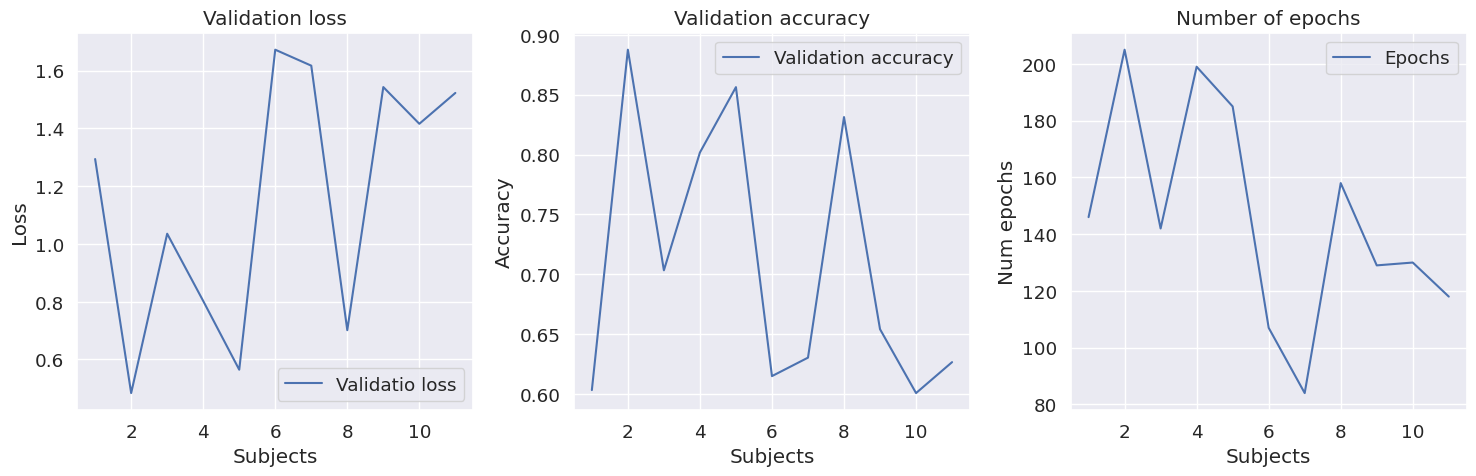


--------------------------------------------------
Internal code size:  200
Batch size:  30
Learnig rate:  0.0001
Average validation loss:  1.150376
Average validation accuracy:  0.710038
--------------------------------------------------


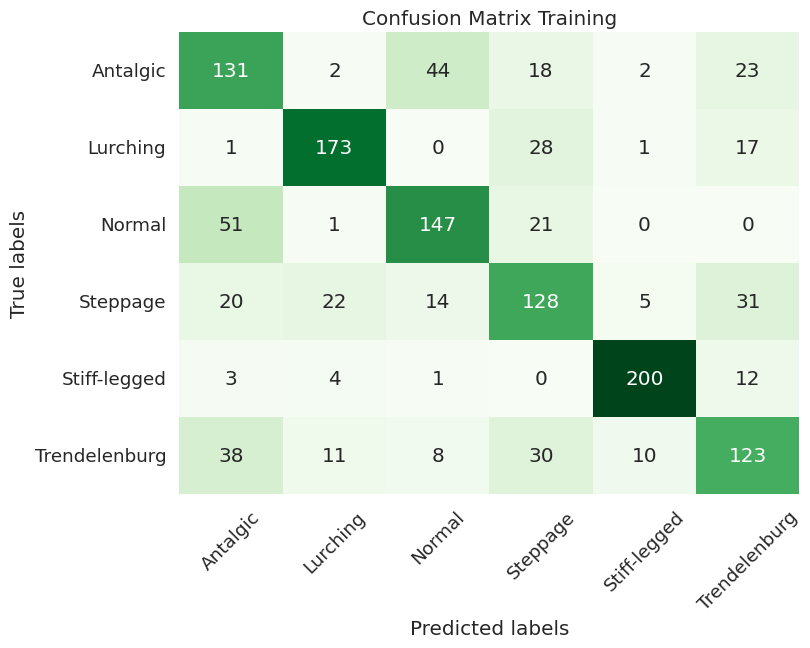

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

s = np.arange(1, 12)

ax1.plot(s, validation_loss, 'b', label='Validatio loss')
ax1.set_title('Validation loss')
ax1.set_xlabel('Subjects')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(s, validation_accuracy, 'b', label='Validation accuracy')
ax2.set_title('Validation accuracy')
ax2.set_xlabel('Subjects')
ax2.set_ylabel('Accuracy')
ax2.legend()

ax3.plot(s, epochs, 'b', label='Epochs')
ax3.set_title('Number of epochs')
ax3.set_xlabel('Subjects')
ax3.set_ylabel('Num epochs')
ax3.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

print()
print('--------------------------------------------------')
print('Internal code size: ', code_size)
print('Batch size: ', batch_sk)
print('Learnig rate: ', lr)
print('Average validation loss: ', np.round(np.mean(validation_loss), 6))
print('Average validation accuracy: ', np.round(np.mean(validation_accuracy), 6))
print('--------------------------------------------------')

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap="Greens", cbar=False,
            xticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'],
            yticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'])
plt.xticks(rotation=45)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Training')
plt.show()

In [26]:
def class_specific_metrics(cm, class_labels = ['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg']):
    # Compute the confusion matrix

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [27]:
df = class_specific_metrics(conf_matrix)
df

,Accuracy,Sensitivity,Specificity,Precision
Antalgic,0.846970,0.595455,0.897273,0.536885
Lurching,0.934091,0.786364,0.963636,0.812207
Normal,0.893939,0.668182,0.939091,0.686916
Steppage,0.856818,0.581818,0.911818,0.568889
Stiff-legged,0.971212,0.909091,0.983636,0.917431
Trendelenburg,0.863636,0.559091,0.924545,0.597087
